In [1]:
from os import getcwd, path, listdir, path
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import layers, losses, optimizers, Sequential, backend, utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import data, image
from numpy import argmax, concatenate
from gc import collect

# Constants

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SEED = 123
DS_PATH = path.join(Path(getcwd()).parents[0], 'dataset')
ALL_PATH = path.join(DS_PATH, 'all_data')
TRAIN_PATH = path.join(DS_PATH, 'train')
VALID_PATH = path.join(DS_PATH, 'valid')
CATEGORIES = sorted([ dir_name for dir_name in listdir(ALL_PATH) if path.isdir(path.join(ALL_PATH, dir_name)) ]) # DS_PATH

# Import dataset

In [3]:
def file_count(dir_name: str) -> int:
    return len(concatenate([i for _, i in dir_name], axis=0))
# pip install referencing -U
# pip install jsonschema -U

In [4]:
train_ds, valid_ds = utils.image_dataset_from_directory(ALL_PATH,
                                                            #color_mode='grayscale',
                                                            subset='both',
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=SEED,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True
                                                            )

count = (2 * data.experimental.cardinality(valid_ds)) // 5
test_ds = valid_ds.take(count)
valid_ds = valid_ds.skip(count)

print("Using", file_count(test_ds), "files for testing and", file_count(valid_ds), "files for validation.")

Found 2447 files belonging to 5 classes.
Using 1958 files for training.
Using 489 files for validation.
Using 192 files for testing and 297 files for validation.


# Dataset visualization

In [15]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    # layers.RandomZoom(-0.1),
    # layers.RandomTranslation(0.1, 0.1)
    ])

def preprocess(img, label):
    return data_augmentation(image.per_image_standardization(img)), label

train_ds = train_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)

valid_ds = valid_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)

test_ds = test_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)

31 total batches
(64, 224, 224, 3) (64, 5)


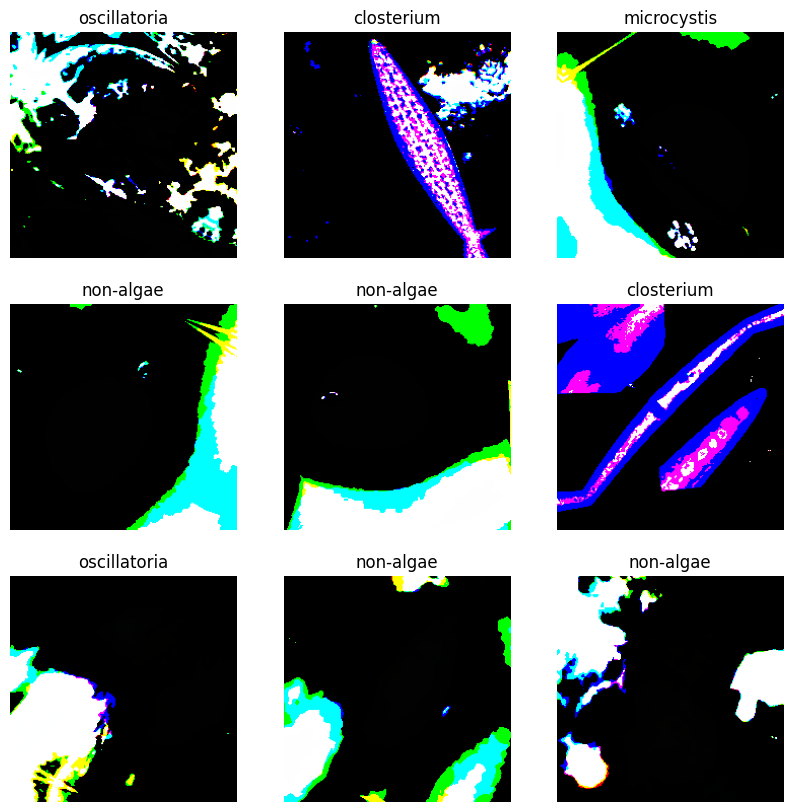

In [16]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

In [17]:
def reset_keras(model, has_model: bool = True):
    backend.clear_session()
    if has_model: del model
    collect()

# Build and compile model

In [18]:
reset_keras(None, False)

# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

def build_model():
  model = Sequential([
    layers.Input(shape=(images.shape[1:])),# batch_size=images.shape[0]),

    layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.BatchNormalization(momentum=0.9),

    layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=1),
    layers.BatchNormalization(momentum=0.9),

    layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=2, activation='relu'),
    layers.MaxPooling2D(pool_size=3, strides=1),
    layers.BatchNormalization(momentum=0.9),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),# input_shape=(prod(image_batch.shape[1:]),)),
    layers.BatchNormalization(momentum=0.9),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(momentum=0.9),
      
    layers.Dense(len(CATEGORIES), activation='softmax')
  ])

  # model = Sequential([
  #     layers.Input(shape=(images.shape[1:])),# batch_size=images.shape[0]),
  #     layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(pool_size=2),
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.25),

  #     layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(pool_size=2),
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.25),

  #     layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
  #     layers.MaxPooling2D(pool_size=2),
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.25),

  #     layers.Flatten(),

  #     layers.Dense(512, activation='relu'),
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.5),

  #     layers.Dense(256, activation='relu'),
  #     layers.BatchNormalization(),
  #     layers.Dropout(0.5),
      
  #     layers.Dense(len(CATEGORIES), activation='softmax')
  # ])

  return model

In [25]:
def compile(model) -> None:
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=1e-3),
              loss=losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train model

In [29]:
EPOCHS = 10
VERBOSE = 1
MONITOR = 'val_loss'
MODE = 'min'

def spe(dataset) -> int:
    return file_count(dataset) // BATCH_SIZE

EARLY = EarlyStopping(monitor=MONITOR,
                      patience=20,
                      verbose=VERBOSE,
                      mode=MODE,
                      restore_best_weights=True
                      )

def checkpoint(name: str) -> ModelCheckpoint:
    return ModelCheckpoint(name,
                           monitor=MONITOR,
                           verbose=VERBOSE,
                           save_best_only=True,
                           mode=MODE
                           )

def fit(model, filename: str = "model.keras"):
    return model.fit(train_ds,#.repeat(),
                     validation_data=valid_ds,#.repeat(),
                     epochs=EPOCHS,
                     verbose=VERBOSE,
                     shuffle=True,
                     #steps_per_epoch=spe(train_ds),
                     #validation_steps=spe(valid_ds),
                     callbacks=[checkpoint(filename),EARLY]
                     )

In [30]:
model = build_model()
compile(model)

history = fit(model)
model.summary()

Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 1.5705 - accuracy: 0.5909
Epoch 1: val_loss improved from inf to 0.99080, saving model to model.keras
31/31 [==============================] - 6s 195ms/step - loss: 1.5705 - accuracy: 0.5909 - val_loss: 0.9908 - val_accuracy: 0.7172
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.6828
Epoch 2: val_loss improved from 0.99080 to 0.89349, saving model to model.keras
31/31 [==============================] - 6s 197ms/step - loss: 0.8650 - accuracy: 0.6828 - val_loss: 0.8935 - val_accuracy: 0.7239
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7191
Epoch 3: val_loss did not improve from 0.89349
31/31 [==============================] - 6s 197ms/step - loss: 0.7625 - accuracy: 0.7191 - val_loss: 0.9057 - val_accuracy: 0.7239
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.7467
Epoch 4: val_loss did not im

# Evaluate accuracy

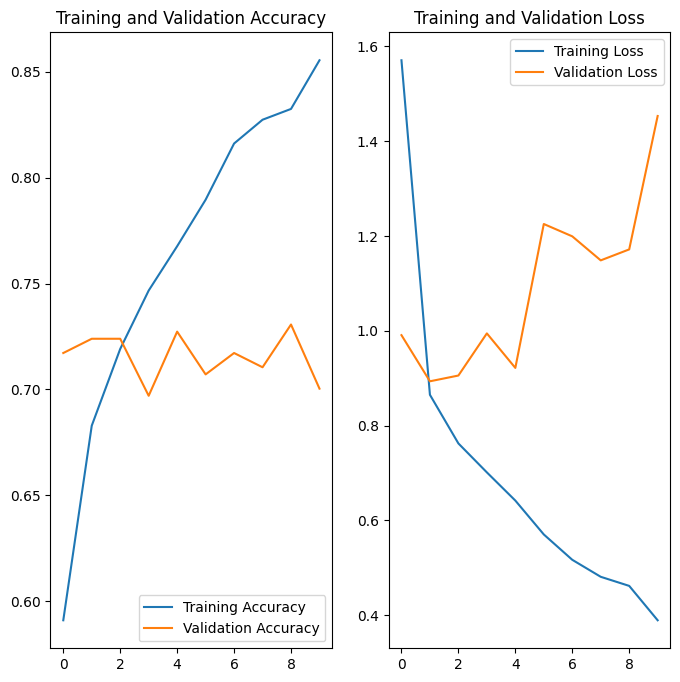

In [31]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
figure(figsize=(8, 8))
subplot(1, 2, 1)
plot(acc, label='Training Accuracy')
plot(val_acc, label='Validation Accuracy')
legend(loc='lower right')
title('Training and Validation Accuracy')

loss, val_loss = history.history['loss'], history.history['val_loss']
subplot(1, 2, 2)
plot(loss, label='Training Loss')
plot(val_loss, label='Validation Loss')
legend(loc='upper right')
title('Training and Validation Loss')
show()

# Testing and predicting

3/3 [==============================] - 0s 54ms/step - loss: 1.6859 - accuracy: 0.6615
77.78% of predictions are correct


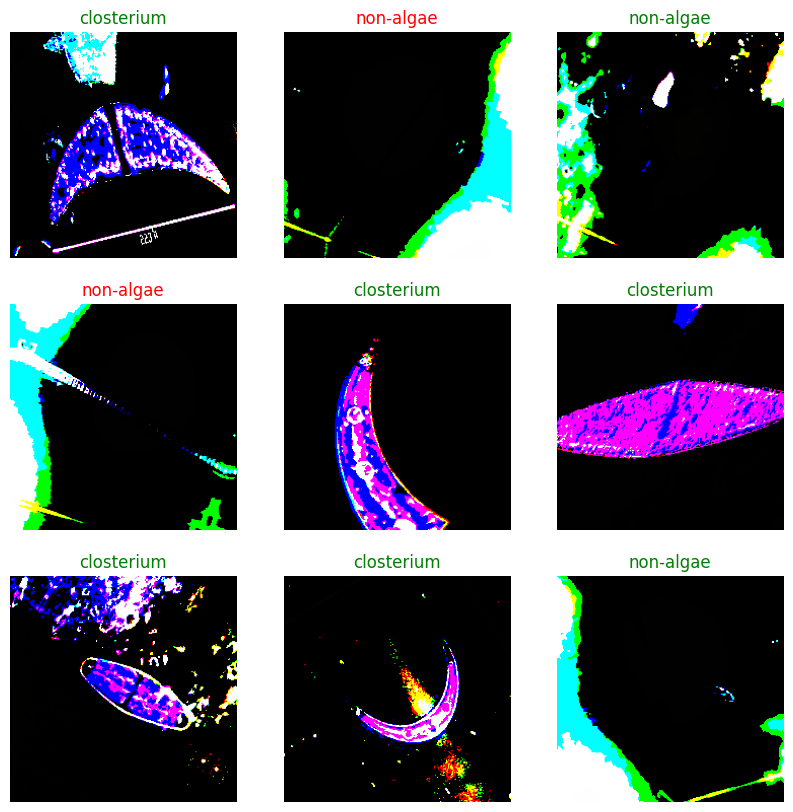

In [32]:
model.evaluate(test_ds, verbose = 1)
probability_model = Sequential([model, layers.Softmax()])
prediction = probability_model.predict(test_ds, verbose = 0)
counter = 0

figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, i + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            color = 'green'
            counter += 1
        else: color = 'red'

        title(predict, fontdict={'color': color})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")

In [33]:
reset_keras(model)